<a href="https://colab.research.google.com/github/shobhanb/ml-nlp-practice/blob/master/NLP_IMDB_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing ML practice
**Sentiment classification - IMDB Reviews dataset**

Version 1.0
* TFDS for data retrieval
* NLTK for stop words / basic stuff
* Keras for Tokens / Embed / RNN model

# Conclusion

Got to max Val/Test accuracy of 85% after trying various parameters of max_words, embedding dim & layers.

Bidirectional w/ LSTM & Dropout gave the best output within 5 epochs

In [106]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import os, random, datetime

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.data.experimental import AUTOTUNE
tfds.disable_progress_bar()

import nltk, string, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [79]:
# Since Test is same size as Train (25k) - let's split Test into Validation & Test 50/50

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'imdb_reviews/plain_text', 
    split=['train', 'test[:50%]', 'test[50%:]'], 
    as_supervised=True, 
    with_info=True, 
    shuffle_files=True
)



In [80]:
for a, b in ds_train.take(4):
    print(a)
    print(b)
    


tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [ ]:

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

ds_val = ds_val.cache()
ds_test = ds_test.cache()


In [93]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()



def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text


def clean_texts_ds(ds):
    sentences, labels = [], []
    for texts, label in iter(ds):
        sentences.append(clean_text(texts.numpy().decode()))
        labels.append(label)
    return (sentences, np.asarray(labels))


train_sentences, train_labels = clean_texts_ds(ds_train)
val_sentences, val_labels = clean_texts_ds(ds_val)
test_sentences, test_labels = clean_texts_ds(ds_test)

print('Train Length: {}\nVal Length: {}\nTest Length: {}'
    .format(len(train_sentences), len(val_sentences), len(test_sentences)))


Train Length: 25000
Val Length: 12500
Test Length: 12500


In [122]:
print('Distribution of positive / negative labels in\nTrain: {}\nVal: {}\nTest: {}'
    .format(train_labels.mean(), val_labels.mean(), test_labels.mean()))

Distribution of positive / negative labels in
Train: 0.5
Val: 0.49672
Test: 0.50328


In [94]:

def check_maxlen(sentences_list):
    maxlen = 0
    for sentence in sentences_list:
        sentence_len = len(sentence.strip().split())
        if sentence_len > maxlen:
            maxlen = sentence_len
    return maxlen

print('Train max words: {}\nVal max words: {}\nTest max words: {}'
    .format(check_maxlen(train_sentences), check_maxlen(val_sentences), check_maxlen(test_sentences)))

Train max words: 1482
Val max words: 1265
Test max words: 1236


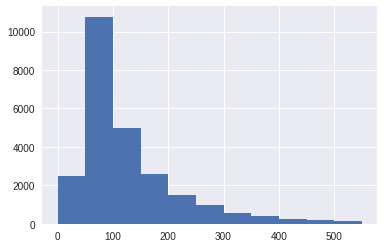

In [114]:
train_len = []
for sentence in train_sentences:
    train_len.append(len(sentence.strip().split()))

plt.hist(train_len, bins=np.arange(0,600,50))
plt.show()

In [188]:

top_words=10000
oov_token='<OOV>'
max_length = 200
padding='post'
truncating='post'

tokenizer = Tokenizer(num_words=top_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


def get_padded(sentences):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding, truncating=truncating)
    return padded


train_padded = get_padded(train_sentences)
val_padded = get_padded(val_sentences)
test_padded = get_padded(test_sentences)


vocab_size


103447

In [189]:
embedding_dim = 20
lr = 0.01 

model = tf.keras.Sequential([
    layers.Embedding(top_words, embedding_dim),  
    layers.Bidirectional(layers.LSTM(embedding_dim)),
    layers.Dropout(0.2),
    layers.Dense(embedding_dim*2, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, None, 20)          200000    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 40)                6560      
_________________________________________________________________
dropout_22 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 41        
Total params: 208,241
Trainable params: 208,241
Non-trainable params: 0
_________________________________________________________________


In [190]:
#Callbacks - Not Used

log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb_lrscheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/5))


In [191]:
EPOCHS=10
BATCH_SIZE = 128

history = model.fit(
    train_padded, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_padded, val_labels)
)


Epoch 1/10
196/196 [==============================] - 8s 40ms/step - loss: 0.5056 - accuracy: 0.7560 - val_loss: 0.4801 - val_accuracy: 0.7794
Epoch 2/10
196/196 [==============================] - 7s 34ms/step - loss: 0.3416 - accuracy: 0.8661 - val_loss: 0.3765 - val_accuracy: 0.8393
Epoch 3/10
196/196 [==============================] - 7s 34ms/step - loss: 0.2454 - accuracy: 0.9036 - val_loss: 0.3893 - val_accuracy: 0.8411
Epoch 4/10
196/196 [==============================] - 7s 34ms/step - loss: 0.1730 - accuracy: 0.9390 - val_loss: 0.3737 - val_accuracy: 0.8478
Epoch 5/10
196/196 [==============================] - 7s 34ms/step - loss: 0.1284 - accuracy: 0.9574 - val_loss: 0.4472 - val_accuracy: 0.8410
Epoch 6/10
196/196 [==============================] - 7s 34ms/step - loss: 0.1051 - accuracy: 0.9660 - val_loss: 0.4967 - val_accuracy: 0.8410
Epoch 7/10
196/196 [==============================] - 7s 34ms/step - loss: 0.0797 - accuracy: 0.9753 - val_loss: 0.5801 - val_accuracy: 0.8375

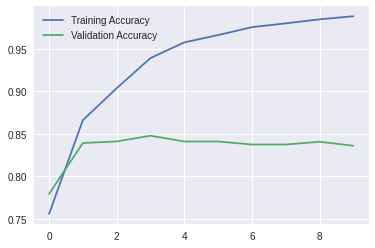

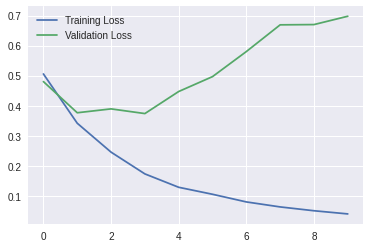

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()

plt.show()


In [193]:
model.evaluate(test_padded, test_labels)

391/391 [==============================] - 5s 12ms/step - loss: 0.7028 - accuracy: 0.8311


[0.7027626633644104, 0.8311200141906738]